## <font color='red'>CONVERT ALL STEPS INTO SPARK?!</font>

## This notebook contains the flow for traditional machine learning steps:

 1. data import
 2. data wrangling for NLP
 3. word cloud
 4. train-test-hold data split
 5. learning curve and imbalance data evaluation 
 6. BOW (bag of words) machine learning 
     small sample on algorithms comparison 
     hyper-parameter turning  on GBX and LogisticRegression
     

The data wrangling produces words token for vectorization task, the main processing time is within the stemming and lemmatization step. 

The word cloud is a primitive check on the tokenized words. This basically shows it is most likely not a linear separable problem. 

The data has been spited into training, testing and holding set. The hold out set only been used in the final model evaluation, which is completed unknown for training step.  The train and test data been feed into vectorizer before split (that means the data leakage is accepted in training/testing) 

Although no significant elbow curve, the Initial learning curve evaluation leads to believe 25% of training data can represent reasonable accuracy. The highly unbalanced data leads into the adoption on imbalance library in which the SMOTE data been used for algorithms selection an training (note: the SMOTE does improve the f1-score for Insincere class but play no magic on total score)

Due to the long running time, a smaller training data set (2.5%) been used for quick algorithms comparison before hyper parameter turning.  LogisticRegression and GradientBoostingClassifier went through hyper parameter turning.  best model from both algorithms been refit with full training set and the hold out data set been used to generated prediction for final score report.

## STEP 1 : DATA IMPORT

In [ ]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))

#train_data.head()

## STEP 2 : DATA WRANGLING

In [ ]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 
from joblib import dump, load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text

train_data['origin'] = train_data['question_text']
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character).apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
#print(train_data.head())

#dump(train_data, 'data/train_data.sav')



<B>Data Staging</B>

In [45]:
from joblib import dump, load

train_data = load('data/train_data.sav')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [ ]:
%%time

from joblib import dump, load

train_text_lemma = train_data['question_text_lemma']
train_text_stem = train_data['question_text_stem']
train_target = train_data['target']

dump(train_target, 'data/target.sav')
dump(train_text_lemma, 'data/question_text_lemma.sav')
dump(train_text_stem, 'data/question_text_stem.sav')

## STEP 3 : WORD CLOUD  (optional)

Just for fun, from <B>[Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)</B>

In [ ]:
#?WordCloud

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def word_cloud(text, name):
    plt.figure(figsize=(15,15))
    wordcloud = WordCloud(max_font_size = 50, max_words = 200, background_color = "white").generate(text)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file("image/"+ name + ".png")

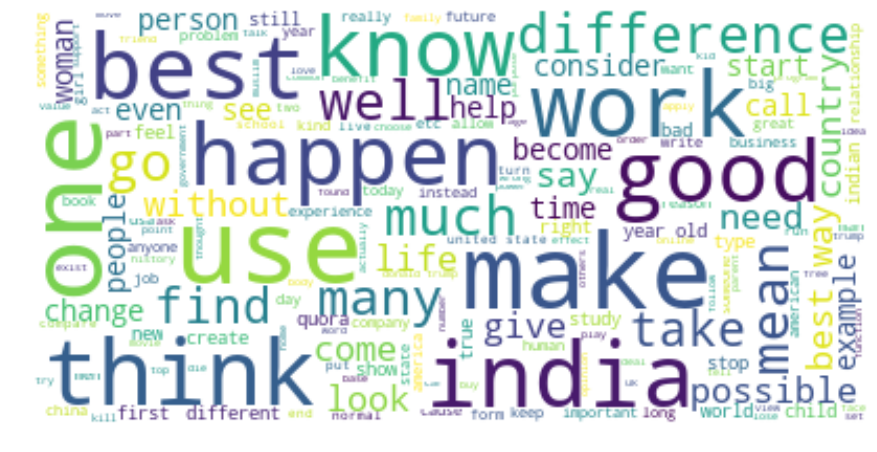

In [49]:
text = " ".join(question for question in train_data.question_text_lemma)
word_cloud(text, 'all_words')

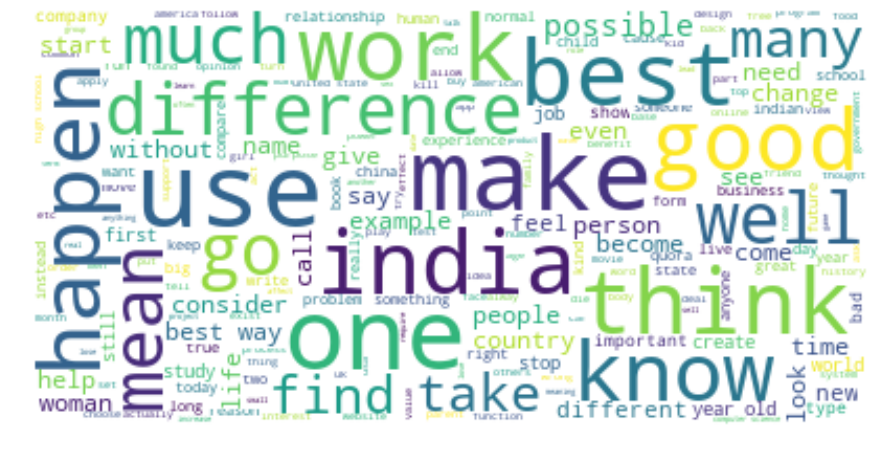

In [50]:
text = " ".join(question for question in train_data.loc[train_data.target == 0,'question_text_lemma'])
word_cloud(text, 'positive_words')

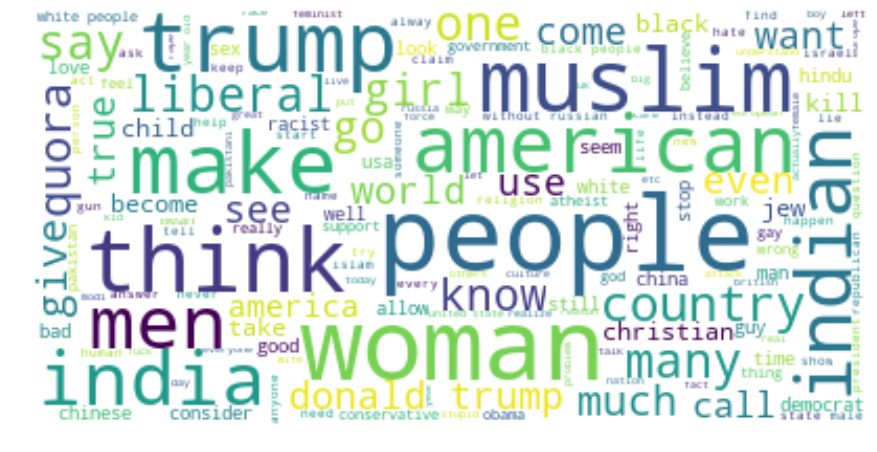

In [51]:
text = " ".join(question for question in train_data.loc[train_data.target == 1,'question_text_lemma'])
word_cloud(text, 'negative_words')

<B>sample positive and negative records</B>

In [66]:
p = train_data.loc[(train_data['target'] == 0), ['question_text','origin','question_text_lemma']]
n = train_data.loc[(train_data['target'] == 1), ['question_text','origin','question_text_lemma']]


In [70]:
print(n.shape, p.shape)

(80799, 3) (1225221, 3)


In [72]:
n[25:30]

,question_text,origin,question_text_lemma
439,peoples india seems hypocritical womans empowe...,How peoples in India seems hypocritical about ...,people india seem hypocritical woman empowerment
460,much political fumbling take republicans turn ...,How much more political fumbling will it take ...,much political fumble take republican turn trump
496,americans prefer show somewhere rather face ev...,Why do Americans prefer just to not show up so...,american prefer show somewhere rather face eve...
538,liberals prochoice choices must approved first...,"Liberals are pro-choice, but the choices must ...",liberal prochoice choice must approve first ac...
544,south indian dishes prepared north indians tas...,Why are South Indian dishes which are prepared...,south indian dish prepared north indian tasty ...


In [74]:
p[25:30]

,question_text,origin,question_text_lemma
26,two democracies never ever went full fledged w...,Why haven't two democracies never ever went fo...,two democracy never ever go full fledge war stop
27,top cbse 6 months,How can I top CBSE in 6 months?,top cbse 6 month
28,know visiting mcleodganj triund trek,What should I know before visiting Mcleodganj ...,know visit mcleodganj triund trek
29,modern military submarines reduce noise achiev...,How do modern military submarines reduce noise...,modern military submarine reduce noise achieve...
31,remove black heads nose,How can I remove black heads which are all ove...,remove black head nose


## STEP 4 : SPLIT DATA FOR TRAINING, TESTING, AND HOLDING

## <font color="red">Step 4.0 code library section</font>

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def split(X, y, vectorizer = CountVectorizer(), test_size = 0.2, hold_size = 0.2):
    #split data to train, test & hold, hold will be completed outside the training vector, 
    X_train, X_hold, y_train, y_hold  = train_test_split(X, y, test_size = hold_size, train_size = 1 - hold_size, random_state = 42, stratify = y)
    X_train = vectorizer.fit_transform(X_train)
    X_hold = vectorizer.transform(X_hold)
    X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, test_size = test_size, train_size = 1 - test_size, random_state = 42, stratify = y_train)
    return  X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer


def fit(X, y, param_grid, estimator):
    search = GridSearchCV(estimator, param_grid, cv = 5,verbose = 1, scoring = 'roc_auc')
    search.fit(X, y)
    best = search.best_estimator_ 
    best.fit(X, y)
    return best


def report(best, X, y, comp, name):
    target_names = ['Sincere', 'Insincere']
    
    print(best)
    predicted = best.predict(X)
    
    #classification_report 
    report = classification_report(y, predicted, target_names = target_names)
    print(report)
    comp[name] = report

    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt = 'd')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()
    
    #roc curve
    probs = best.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:,0], pos_label = 0)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, thresholds1 = roc_curve(y, probs[:,1], pos_label = 1)
    roc_auc1 = auc(fpr1, tpr1)
    
    plt.figure()
    plt.plot(fpr, tpr, color ='blue', lw = 1, label = 'ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot(fpr1, tpr1, color ='red', lw = 1, label = 'ROC curve for insincere (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color ='black', lw = 1, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic' + name)
    plt.legend(loc = "lower right")
    plt.show()

In [2]:
%%time

from joblib import dump, load

train_target =load('data/target.sav')
train_text_lemma = load('data/question_text_lemma.sav')
train_text_stem = load('data/question_text_stem.sav')

CPU times: user 956 ms, sys: 328 ms, total: 1.28 s
Wall time: 1.31 s


In [3]:
%%time

# use lemmatization data 
X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target,)

print(X_train.shape,X_test.shape,X_hold.shape)
print(y_train.shape,y_test.shape,y_hold.shape)
print(vectorizer)


(835852, 196257) (208964, 196257) (261204, 196257)
(835852,) (208964,) (261204,)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
CPU times: user 13.2 s, sys: 375 ms, total: 13.6 s
Wall time: 11.8 s


## STEP 5 : INITIAL EVALUATION

### Evaluate the learning curve on training data size

<font color="red">Although there has no significant elbow point in the plot, 25% of the training data appears as a good smallest set for the ML model comparison step</font>

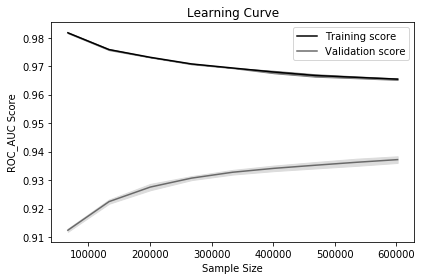

CPU times: user 12min 15s, sys: 13.1 s, total: 12min 28s
Wall time: 3min 8s


In [4]:
%%time

from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)


train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(), X_train, y_train, train_sizes = np.arange(0.1, 1, 0.1), cv = 5, scoring = 'roc_auc')


# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
valid_mean = np.mean(valid_scores, axis = 1)
valid_std = np.std(valid_scores, axis = 1)

# Plot mean accuracy scores for training and test sets
plt.plot(train_sizes, train_mean, color = 'black', label = "Training score",)
plt.plot(train_sizes, valid_mean, color = 'dimgrey', label = "Validation score", )
# Plot accurancy bands for training and test sets
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="gainsboro")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Sample Size")
plt.ylabel("ROC_AUC Score")
plt.tight_layout()
plt.legend(loc = "best")
plt.show()

### Evaluate the validation curve on regularization strength 

<font color="red">GridSearchCV should handle individual parameter selection. This plot just to show the effect for parameter selection</font>

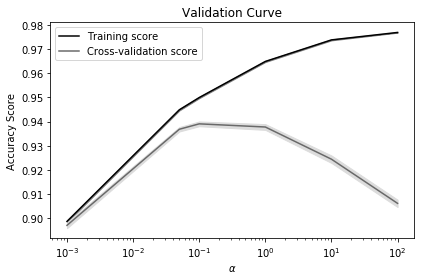

CPU times: user 1.56 s, sys: 361 ms, total: 1.93 s
Wall time: 5min 33s


In [5]:
%%time

import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

# Calculate accuracy on training and test set using range of parameter values
param_range = [0.001, 0.05, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(LogisticRegression(), 
                                             X_train, 
                                             y_train, 
                                             param_name = "C", 
                                             param_range = param_range,
                                             cv = 5, 
                                             scoring = "roc_auc", 
                                             n_jobs = -1)
 
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label = "Training score", color = "black")
plt.plot(param_range, test_mean, label = "Cross-validation score", color = "dimgrey")
# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color = "gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color = "gainsboro")

# Create plot
plt.title("Validation Curve")
plt.xlabel(r"$\alpha$")
plt.xscale('log')
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### Eevaluate the resampling due to imbalanced data   

<font color='red'> As in the early prototype submission, the best f-1 score for insincere class barely reach 0.50 (using 0.5% sample for training), the attempt is to apply [imbalance library](https://imbalanced-learn.readthedocs.io/en/stable/) to improve the f-1 score. To save on computation time, the logistic regression model is used to test different sampling methods. The reason is the logistic regression provides reasonable result in a relatively short time. A few sampling approaches are embedded within modeling algorithm,  a default parameter will be used withs out CV or GridSearch. This is to decide on re-sampling method, not on model optimizing </font> 

<B>The over sampling, under sampling and SMOTE provides similar f-1 score, in which aoc_ROC is 0.94. The ADASYN, SMOTEENN both has lower aoc_ROC score and take longer time to complete.  the SMOTETomek does not complete in a reasonable time that I have to interrupt the thread after 30 hours of running. The Ensemble models report f-1 scores slightly below SMOT, ranging from (0.84 ~ 0.93). The SMOT will be adopted to continue to the next step.     
</B>

In [6]:
sample_test_compare = {}
sample_train_compare = {}

In [5]:
%%time

from sklearn.linear_model import LogisticRegression
org_model = LogisticRegression(solver = 'liblinear').fit(X_train, y_train)


CPU times: user 48.9 s, sys: 496 ms, total: 49.4 s
Wall time: 12.6 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.98    784141
   Insincere       0.75      0.45      0.56     51711

    accuracy                           0.96    835852
   macro avg       0.86      0.72      0.77    835852
weighted avg       0.95      0.96      0.95    835852



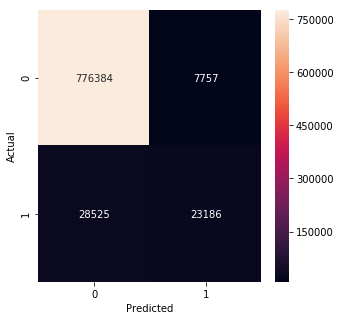

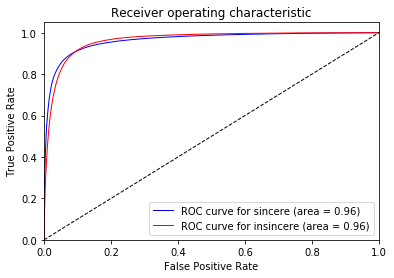

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97    196036
   Insincere       0.68      0.40      0.50     12928

    accuracy                           0.95    208964
   macro avg       0.82      0.69      0.74    208964
weighted avg       0.94      0.95      0.95    208964



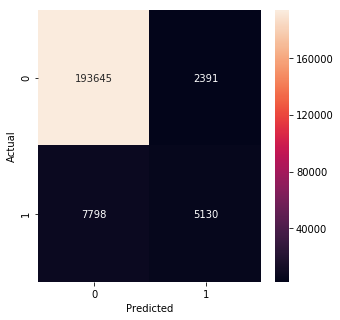

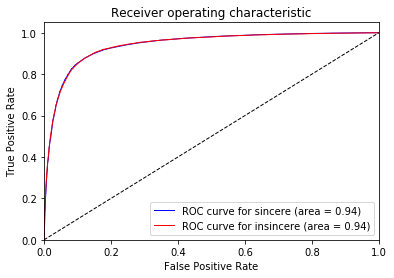

In [11]:
report(org_model, X_train, y_train, sample_train_compare, 'org_model')
report(org_model, X_test, y_test, sample_test_compare, 'org_model')

In [8]:
%%time

#over sampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# dataset X_train, X_test, X_hold, y_train, y_test, y_hold 
ros = RandomOverSampler(random_state = 42)
X_up, y_up = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_up).items()))

/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


[(0, 784141), (1, 784141)]
CPU times: user 2.3 s, sys: 122 ms, total: 2.42 s
Wall time: 1.13 s


In [9]:
%%time
ros_model = LogisticRegression(solver = 'liblinear').fit(X_up, y_up)


CPU times: user 2min 54s, sys: 2.87 s, total: 2min 56s
Wall time: 45.1 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.94      0.92      0.93    784141
   Insincere       0.92      0.94      0.93    784141

    accuracy                           0.93   1568282
   macro avg       0.93      0.93      0.93   1568282
weighted avg       0.93      0.93      0.93   1568282



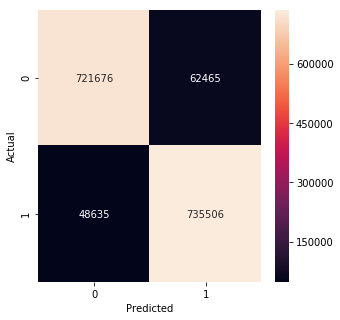

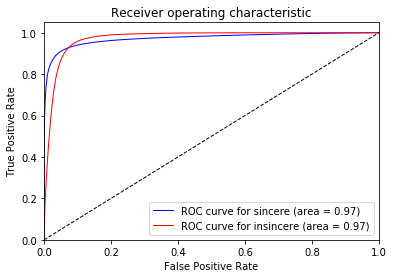

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.91      0.95    196036
   Insincere       0.38      0.82      0.52     12928

    accuracy                           0.91    208964
   macro avg       0.68      0.86      0.74    208964
weighted avg       0.95      0.91      0.92    208964



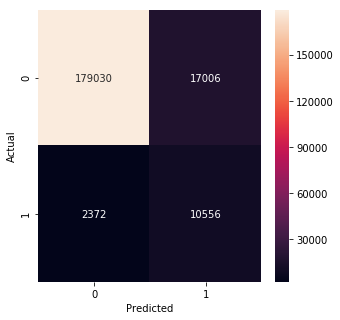

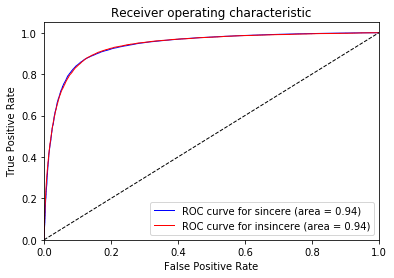

In [17]:
report(ros_model, X_up, y_up, sample_train_compare, 'ros_model')
report(ros_model, X_test, y_test, sample_test_compare, 'ros_model')

[Comparison of the different under-sampling algorithms](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py), As the clustering, neighbour, etc takeing assumption on certain underline structure,it similar to SMOT and will go through significant computation time and possible overfit. let's try simple random samplining  

In [13]:
%%time

#under sampling
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
# from imblearn.under_sampling import  EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
# from imblearn.under_sampling import CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule
# from imblearn.under_sampling import InstanceHardnessThreshold
from collections import Counter

# dataset X_train, X_test, X_hold, y_train, y_test, y_hold 
rus = RandomUnderSampler(random_state = 42)
X_down, y_down = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_down).items()))

[(0, 51711), (1, 51711)]
CPU times: user 955 ms, sys: 45.6 ms, total: 1 s
Wall time: 303 ms


In [14]:
%%time
rus_model = LogisticRegression(solver = 'liblinear').fit(X_down, y_down)

CPU times: user 3.7 s, sys: 53.6 ms, total: 3.76 s
Wall time: 952 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.89      0.94    784141
   Insincere       0.36      0.91      0.52     51711

    accuracy                           0.89    835852
   macro avg       0.68      0.90      0.73    835852
weighted avg       0.95      0.89      0.91    835852



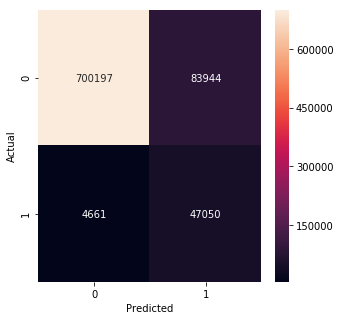

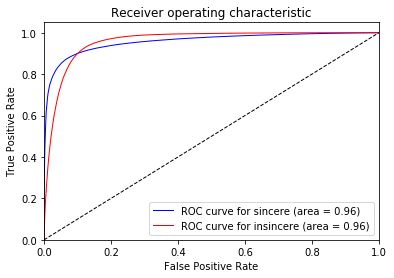

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.89      0.94    196036
   Insincere       0.34      0.86      0.49     12928

    accuracy                           0.89    208964
   macro avg       0.67      0.88      0.72    208964
weighted avg       0.95      0.89      0.91    208964



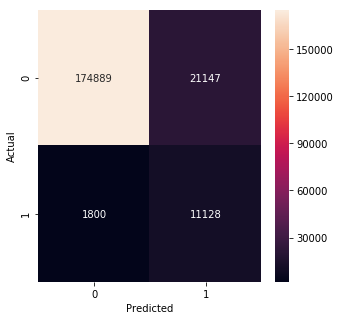

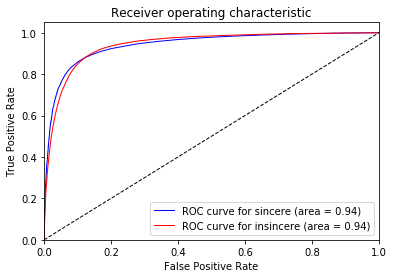

In [15]:
report(rus_model, X_down, y_down, sample_train_compare, 'rus_model')
report(rus_model, X_test, y_test, sample_test_compare, 'rus_model')

In [16]:
%%time

#SMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE, SMOTENC
from collections import Counter

sm = SMOTE(random_state = 42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print(sorted(Counter(y_sm).items()))

[(0, 51711), (1, 51711)]
CPU times: user 15min 18s, sys: 26.1 s, total: 15min 44s
Wall time: 15min 39s


In [75]:
print(sorted(Counter(y_sm).items()))

[(0, 784141), (1, 784141)]


In [18]:
%%time
sm_model = LogisticRegression(solver ='liblinear').fit(X_sm, y_sm)


CPU times: user 2min 30s, sys: 2.21 s, total: 2min 32s
Wall time: 38.8 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.92      0.94    784141
   Insincere       0.92      0.96      0.94    784141

    accuracy                           0.94   1568282
   macro avg       0.94      0.94      0.94   1568282
weighted avg       0.94      0.94      0.94   1568282



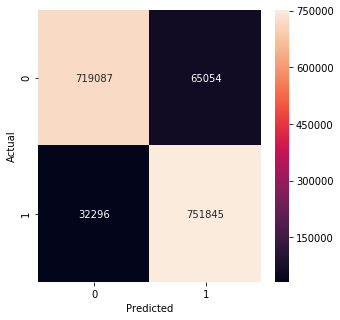

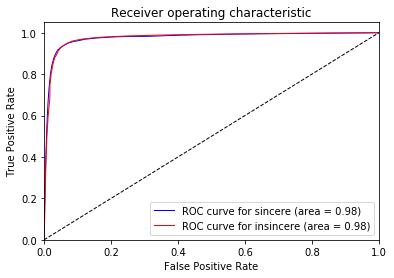

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.90      0.93    196036
   Insincere       0.27      0.56      0.37     12928

    accuracy                           0.88    208964
   macro avg       0.62      0.73      0.65    208964
weighted avg       0.93      0.88      0.90    208964



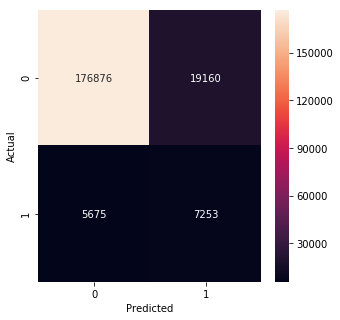

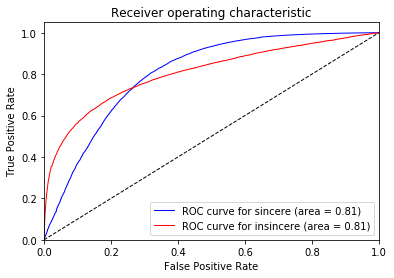

In [19]:
report(sm_model, X_sm, y_sm, sample_train_compare, 'sm_model')
report(sm_model, X_test, y_test, sample_test_compare, 'sm_model')

In [20]:
%%time

#ADASYN
from imblearn.over_sampling import SMOTE, ADASYN

ad = ADASYN(random_state = 42)
X_ad, y_ad = ad.fit_resample(X_train, y_train)
print(sorted(Counter(y_ad).items()))

[(0, 51711), (1, 51711)]
CPU times: user 31min 19s, sys: 3min 58s, total: 35min 18s
Wall time: 31min 47s


In [76]:
print(sorted(Counter(y_ad).items()))

[(0, 784141), (1, 796388)]


In [21]:
%%time
ad_model = LogisticRegression(solver = 'liblinear').fit(X_ad, y_ad)


CPU times: user 4min 5s, sys: 15.1 s, total: 4min 20s
Wall time: 1min 12s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.91      0.93    784141
   Insincere       0.92      0.96      0.94    796388

    accuracy                           0.94   1580529
   macro avg       0.94      0.94      0.94   1580529
weighted avg       0.94      0.94      0.94   1580529



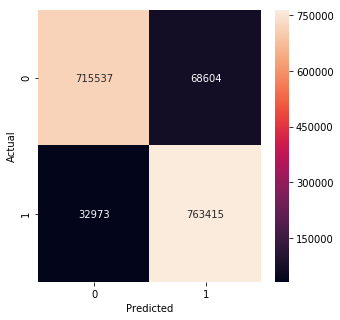

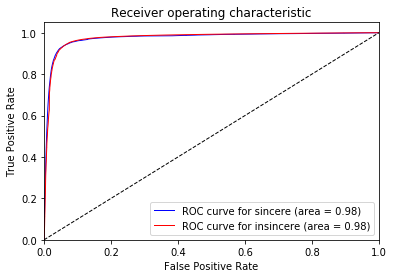

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.90      0.93    196036
   Insincere       0.26      0.56      0.36     12928

    accuracy                           0.88    208964
   macro avg       0.62      0.73      0.64    208964
weighted avg       0.92      0.88      0.90    208964



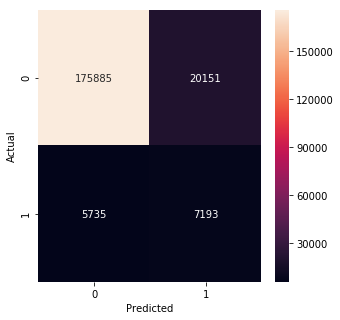

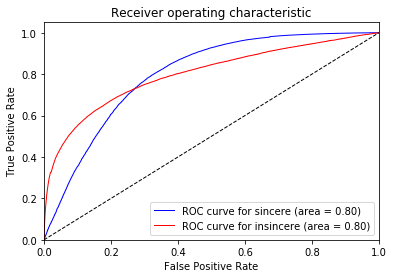

In [22]:
report(ad_model, X_ad, y_ad, sample_train_compare, 'ad_model')
report(ad_model, X_test, y_test, sample_test_compare, 'ad_model')

In [23]:
%%time

#COMBINE UNDER AND OVER
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

sme = SMOTEENN(random_state = 42)
X_sme, y_sme = sme.fit_resample(X_train, y_train)
print(sorted(Counter(y_sme).items()))

[(0, 51711), (1, 51711)]
CPU times: user 16h 42min 30s, sys: 3h 26min 32s, total: 20h 9min 2s
Wall time: 19h 31min 2s


In [77]:
print(sorted(Counter(y_sme).items()))

[(0, 135470), (1, 771099)]


In [24]:
%%time
sme_model = LogisticRegression(solver = 'liblinear').fit(X_sme, y_sme)


CPU times: user 16.9 s, sys: 184 ms, total: 17 s
Wall time: 4.35 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.98      0.95      0.97    135470
   Insincere       0.99      1.00      0.99    771099

    accuracy                           0.99    906569
   macro avg       0.98      0.97      0.98    906569
weighted avg       0.99      0.99      0.99    906569



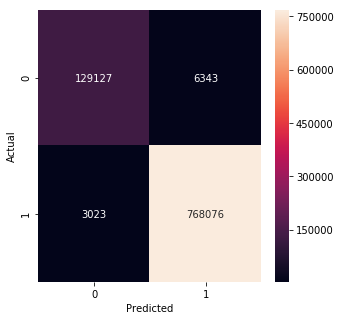

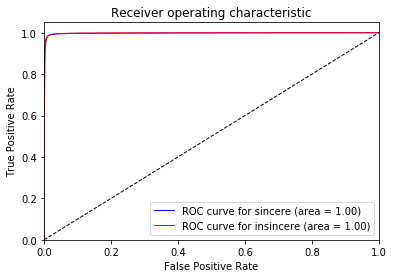

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.59      0.74    196036
   Insincere       0.13      0.91      0.23     12928

    accuracy                           0.61    208964
   macro avg       0.56      0.75      0.48    208964
weighted avg       0.94      0.61      0.71    208964



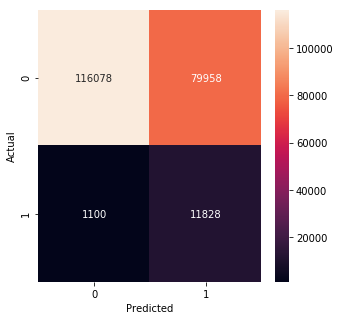

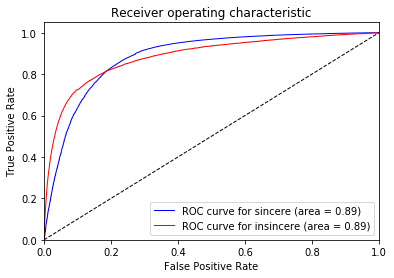

In [25]:
report(sme_model, X_sme, y_sme, sample_train_compare, 'sme_model')
report(sme_model, X_test, y_test, sample_test_compare, 'sme_model')

<B>The following been terminated as it runs 30+ hours without result</B>

In [ ]:
# %%time

# #COMBINE UNDER AND OVER
# from imblearn.combine import SMOTEENN, SMOTETomek
# from collections import Counter

# smt = SMOTETomek(random_state = 42)
# X_smt, y_smt = smt.fit_resample(X_train, y_train)
# print(sorted(Counter(y_down).items()))


In [ ]:
# %%time
# smt_model = LogisticRegression(solver = 'liblinear').fit(X_smt, y_smt)

In [ ]:
# report(smt_model, X_smt, y_smt, sample_train_compare, 'smt_model')
# report(smt_model, X_test, y_test, sample_test_compare, 'smt_model')

[Ensemble of samplers](https://imbalanced-learn.readthedocs.io/en/stable/ensemble.html) provides several ensemble estimator via conroling the sampling in the process, such that the booster, to get balanced sample in each steps

In [26]:
%%time

# Ensemble of samplers
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bbc = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(),
                                sampling_strategy = 'auto',replacement = False,random_state = 42)

bbc_model = bbc.fit(X_train, y_train) 

/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


CPU times: user 14min 23s, sys: 1.32 s, total: 14min 25s
Wall time: 14min 6s


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

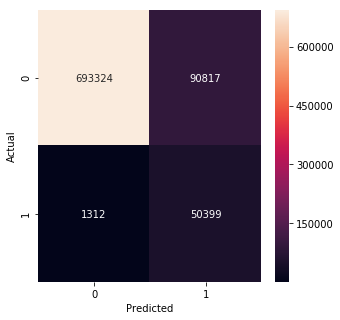

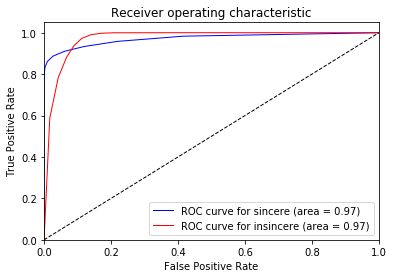

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

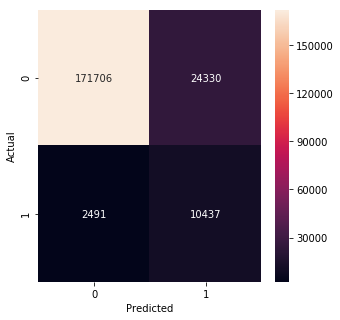

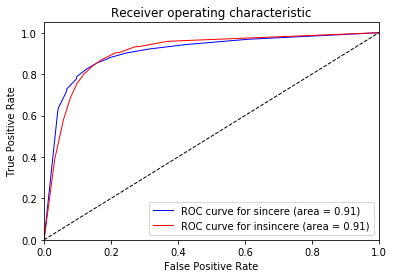

In [27]:
report(bbc_model, X_train, y_train, sample_train_compare, 'bbc_model')
report(bbc_model, X_test, y_test, sample_test_compare, 'bbc_model')

In [28]:
%%time

# Ensemble of samplers
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators = 100, random_state = 42)
brf_model = brf.fit(X_train, y_train) 

CPU times: user 10min 54s, sys: 3.28 s, total: 10min 58s
Wall time: 9min 37s


BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=42,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.79      0.88    784141
   Insincere       0.23      0.93      0.37     51711

    accuracy                           0.80    835852
   macro avg       0.61      0.86      0.63    835852
weighted avg       0.95      0.80      0.85    835852



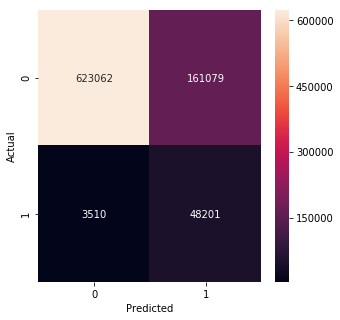

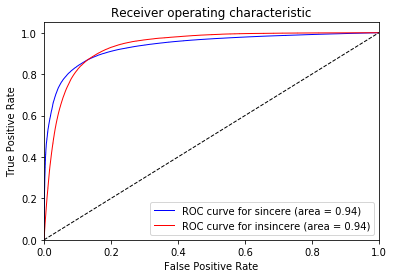

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=42,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.79      0.88    196036
   Insincere       0.23      0.92      0.36     12928

    accuracy                           0.80    208964
   macro avg       0.61      0.86      0.62    208964
weighted avg       0.95      0.80      0.85    208964



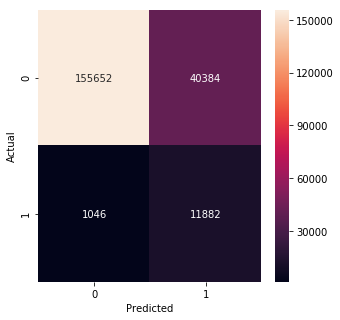

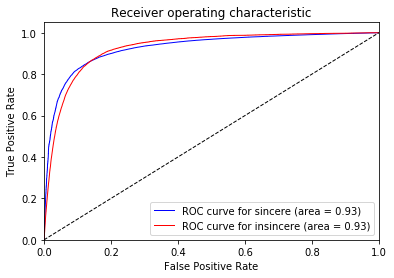

In [29]:
report(brf_model, X_train, y_train, sample_train_compare, 'brf_model')
report(brf_model, X_test, y_test, sample_test_compare, 'brf_model')

In [30]:
%%time

# Ensemble of samplers
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(random_state = 42)
rusboost_model = rusboost.fit(X_train, y_train) 

CPU times: user 11min 48s, sys: 3.99 s, total: 11min 52s
Wall time: 10min 35s


RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42, replacement=False,
                   sampling_strategy='auto')
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97    784141
   Insincere       0.66      0.30      0.41     51711

    accuracy                           0.95    835852
   macro avg       0.81      0.64      0.69    835852
weighted avg       0.94      0.95      0.94    835852



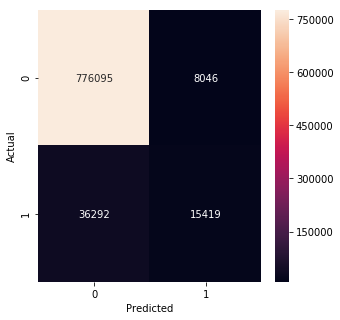

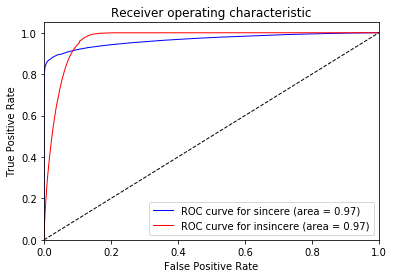

RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42, replacement=False,
                   sampling_strategy='auto')
              precision    recall  f1-score   support

     Sincere       0.95      0.99      0.97    196036
   Insincere       0.46      0.19      0.27     12928

    accuracy                           0.94    208964
   macro avg       0.71      0.59      0.62    208964
weighted avg       0.92      0.94      0.92    208964



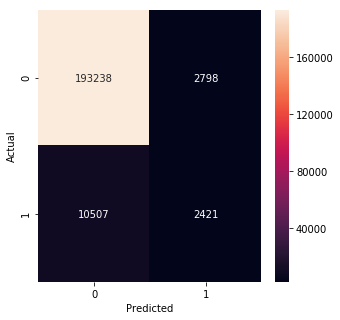

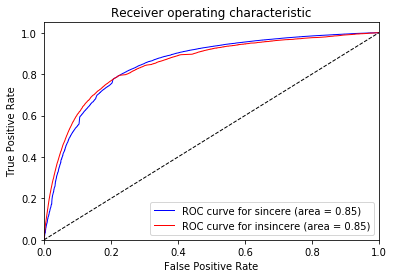

In [31]:
report(rusboost_model, X_train, y_train, sample_train_compare, 'rusboost_model')
report(rusboost_model, X_test, y_test, sample_test_compare, 'rusboost_model')


In [32]:
%%time

# Ensemble of samplers
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=42)
eec_model = eec.fit(X_train, y_train) 


CPU times: user 58min 47s, sys: 5.49 s, total: 58min 53s
Wall time: 52min 52s


EasyEnsembleClassifier(base_estimator=None, n_estimators=10, n_jobs=1,
                       random_state=42, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.98      0.88      0.93    784141
   Insincere       0.29      0.71      0.41     51711

    accuracy                           0.87    835852
   macro avg       0.63      0.80      0.67    835852
weighted avg       0.94      0.87      0.90    835852



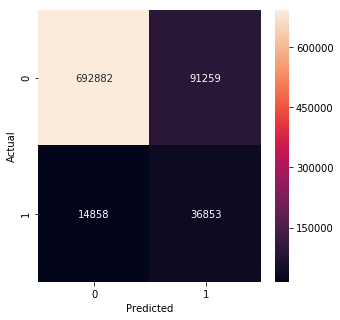

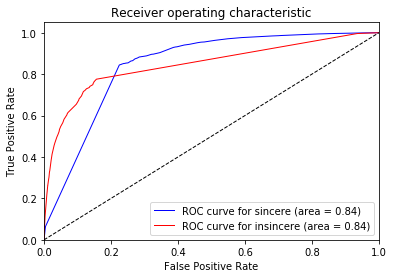

EasyEnsembleClassifier(base_estimator=None, n_estimators=10, n_jobs=1,
                       random_state=42, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.98      0.88      0.93    196036
   Insincere       0.29      0.71      0.41     12928

    accuracy                           0.87    208964
   macro avg       0.63      0.80      0.67    208964
weighted avg       0.94      0.87      0.90    208964



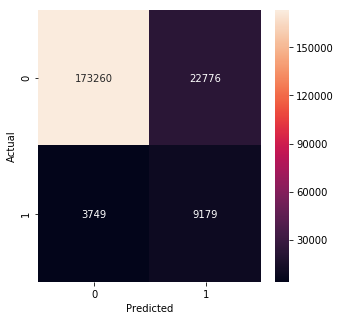

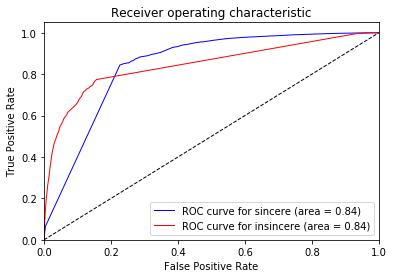

In [34]:
report(eec_model, X_train, y_train, sample_train_compare, 'eec_model')
report(eec_model, X_test, y_test, sample_test_compare, 'eec_model')

<B>Report matrix here</B>

In [35]:
# report imbalanced sample approach here
for key in sample_train_compare:
    print(key)
    print(sample_train_compare[key])


org_model
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.98    784141
   Insincere       0.75      0.45      0.56     51711

    accuracy                           0.96    835852
   macro avg       0.86      0.72      0.77    835852
weighted avg       0.95      0.96      0.95    835852

ros_model
              precision    recall  f1-score   support

     Sincere       0.94      0.92      0.93    784141
   Insincere       0.92      0.94      0.93    784141

    accuracy                           0.93   1568282
   macro avg       0.93      0.93      0.93   1568282
weighted avg       0.93      0.93      0.93   1568282

rus_model
              precision    recall  f1-score   support

     Sincere       0.99      0.89      0.94    784141
   Insincere       0.36      0.91      0.52     51711

    accuracy                           0.89    835852
   macro avg       0.68      0.90      0.73    835852
weighted avg       0.95      0.89      0.91 

In [36]:
# report imbalanced sample approach here
for key in sample_test_compare:
    print(key)
    print(sample_test_compare[key])

org_model
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97    196036
   Insincere       0.68      0.40      0.50     12928

    accuracy                           0.95    208964
   macro avg       0.82      0.69      0.74    208964
weighted avg       0.94      0.95      0.95    208964

ros_model
              precision    recall  f1-score   support

     Sincere       0.99      0.91      0.95    196036
   Insincere       0.38      0.82      0.52     12928

    accuracy                           0.91    208964
   macro avg       0.68      0.86      0.74    208964
weighted avg       0.95      0.91      0.92    208964

rus_model
              precision    recall  f1-score   support

     Sincere       0.99      0.89      0.94    196036
   Insincere       0.34      0.86      0.49     12928

    accuracy                           0.89    208964
   macro avg       0.67      0.88      0.72    208964
weighted avg       0.95      0.89      0.91 

<B>data staging</B>

In [39]:
# save extra 
from joblib import dump, load

dump(X_up, 'data/ros_X_train.sav')
dump(y_up, 'data/ros_y_train.sav')

dump(X_down, 'data/rus_X_train.sav')
dump(y_down, 'data/rus_y_train.sav')

dump(X_sm, 'data/sm_X_train.sav')
dump(y_sm, 'data/sm_y_train.sav')

dump(X_ad, 'data/ad_X_train.sav')
dump(y_ad, 'data/ad_y_train.sav')

dump(X_sme, 'data/sme_X_train.sav')
dump(y_sme, 'data/sme_y_train.sav')

['data/sme_y_train.sav']

In [40]:
##dump data for next step 

from joblib import dump, load
#X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer

dump(X_sm, 'data/sample_X_train.sav')
dump(y_sm, 'data/sample_y_train.sav')
dump(X_test, 'data/sample_X_test.sav')
dump(y_test, 'data/sample_y_test.sav')
dump(X_hold, 'data/sample_X_hold.sav')
dump(y_hold, 'data/sample_y_hold.sav')
dump(vectorizer, 'data/sample_vectorizer.sav')


['data/sample_vectorizer.sav']

In [44]:
print(X_sm.shape)
print(y_sm.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_hold.shape)
print(y_hold.shape)
print(type(vectorizer))

(1568282, 196257)
(1568282,)
(1568282, 196257)
(1568282,)
(208964, 196257)
(208964,)
(261204, 196257)
(261204,)
<class 'sklearn.feature_extraction.text.CountVectorizer'>


## STEP 6 : BAG OF WORDS USING TRADITIONAL MACHINE LEARNING 

In [42]:
##load data for step 

from joblib import dump, load
#X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer

X_train =load('data/sample_X_train.sav')
y_train =load('data/sample_y_train.sav')
X_test =load('data/sample_X_test.sav')
y_test =load('data/sample_y_test.sav')
X_hold =load('data/sample_X_hold.sav')
y_hold =load('data/sample_y_hold.sav')
vectorizer =load('data/sample_vectorizer.sav')

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_hold.shape)
print(y_hold.shape)
print(type(vectorizer))

(1568282, 196257)
(1568282,)
(208964, 196257)
(208964,)
(261204, 196257)
(261204,)
<class 'sklearn.feature_extraction.text.CountVectorizer'>


## Step 6.1 Quick ML Algorithm Comparison Using Small Sample Size

<font color = 'blue'>This step uses 2.5% training data on selected algorithms for training and uses the same test data for performance comparison. It aims to decide the best algorithm to perform hyperparameter tuning. Some estimator also has class weight parameter such that the class_weight='balanced' will consider the imbalanced data and assign the weight accordingly. Just a note here that this class_weight parameter will be adopted if applicable even the data underwent the SMOT process and balanced. </font>


In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV

# to store different accuracy result using X_test/y_test
alg_train_compare = {} 
alg_test_compare = {} 

X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size = 0.975, train_size = 0.025, random_state = 42, stratify = y_train)
print(X_train.shape, y_train.shape)


(39207, 196257) (39207,)


In [79]:
%%time

#for Algorithm (naive_bayes)
from sklearn.naive_bayes import ComplementNB

nbModel = ComplementNB().fit(X_train, y_train)

CPU times: user 14.6 ms, sys: 27.8 ms, total: 42.3 ms
Wall time: 41.6 ms


ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
              precision    recall  f1-score   support

     Sincere       0.80      0.97      0.88     19603
   Insincere       0.96      0.76      0.85     19604

    accuracy                           0.86     39207
   macro avg       0.88      0.86      0.86     39207
weighted avg       0.88      0.86      0.86     39207



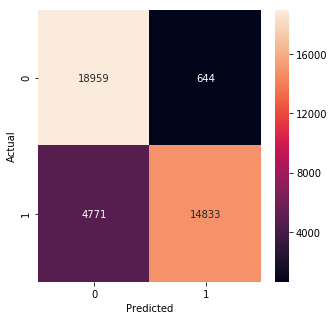

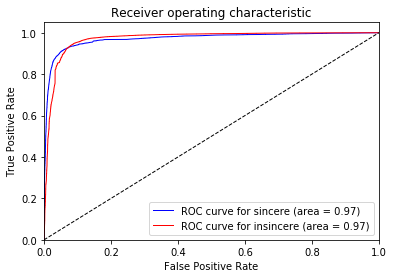

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.95      0.95    196036
   Insincere       0.36      0.47      0.41     12928

    accuracy                           0.92    208964
   macro avg       0.66      0.71      0.68    208964
weighted avg       0.93      0.92      0.92    208964



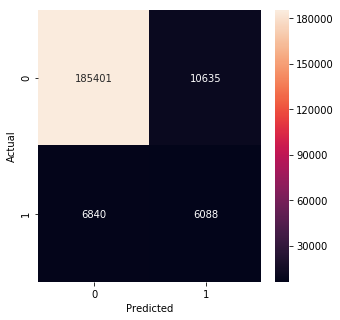

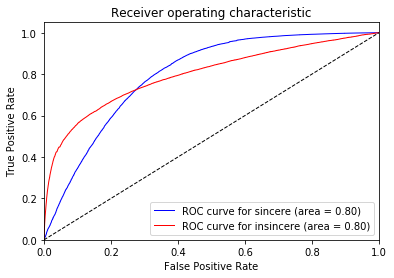

In [80]:
report(nbModel, X_train, y_train, alg_train_compare, 'nbModel')
report(nbModel, X_test, y_test, alg_test_compare, 'nbModel')

In [81]:
%%time

#for Algorithm (logisticRegression)
from sklearn.linear_model import LogisticRegression

lgModel = LogisticRegression(solver = 'liblinear', random_state = 42,class_weight = 'balanced').fit(X_train, y_train)


CPU times: user 1.17 s, sys: 20.9 ms, total: 1.2 s
Wall time: 316 ms


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.93      0.94     19603
   Insincere       0.93      0.96      0.94     19604

    accuracy                           0.94     39207
   macro avg       0.94      0.94      0.94     39207
weighted avg       0.94      0.94      0.94     39207



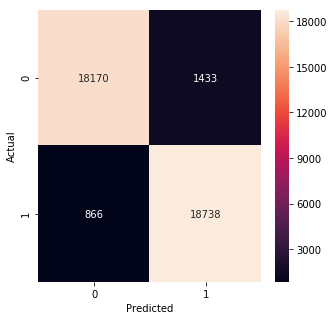

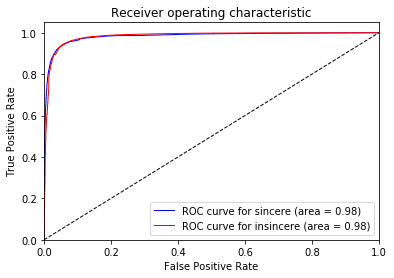

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.85      0.91    196036
   Insincere       0.21      0.59      0.31     12928

    accuracy                           0.84    208964
   macro avg       0.59      0.72      0.61    208964
weighted avg       0.92      0.84      0.87    208964



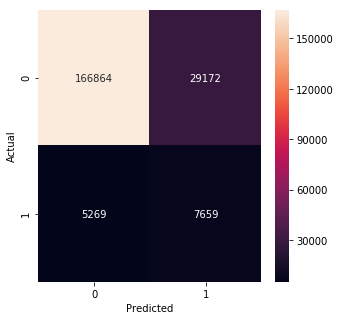

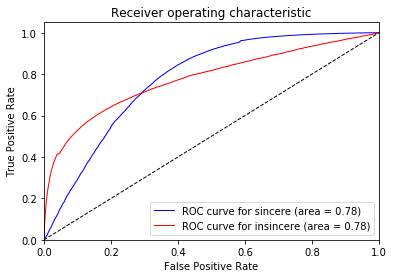

In [82]:
report(lgModel, X_train, y_train, alg_train_compare, 'lgModel')
report(lgModel, X_test, y_test, alg_test_compare, 'lgModel')

In [83]:
%%time

#for Algorithm (SVC)
from sklearn.svm import SVC, LinearSVC

svcModel = SVC(random_state = 42, gamma='scale', class_weight = 'balanced', probability = True).fit(X_train, y_train)


CPU times: user 3min 57s, sys: 2.62 s, total: 4min
Wall time: 4min


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.97      0.96     19603
   Insincere       0.97      0.95      0.96     19604

    accuracy                           0.96     39207
   macro avg       0.96      0.96      0.96     39207
weighted avg       0.96      0.96      0.96     39207



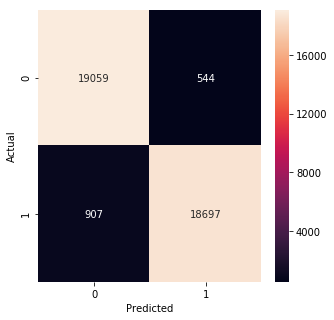

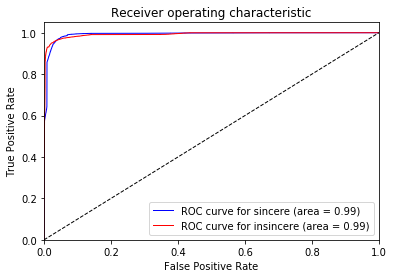

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.93      0.94    196036
   Insincere       0.18      0.21      0.19     12928

    accuracy                           0.89    208964
   macro avg       0.56      0.57      0.57    208964
weighted avg       0.90      0.89      0.89    208964



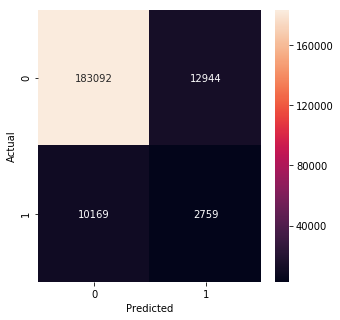

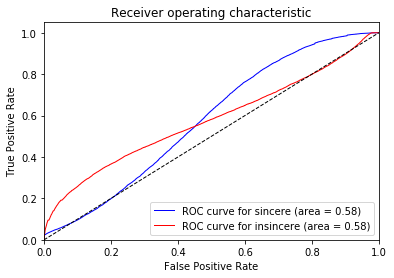

In [84]:
report(svcModel, X_train, y_train, alg_train_compare, 'svcModel')
report(svcModel, X_test, y_test, alg_test_compare, 'svcModel')

In [85]:
%%time

#for Algorithm (RandomForest)
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(random_state = 42,class_weight = 'balanced').fit(X_train, y_train)


/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 52.2 s, sys: 94.7 ms, total: 52.3 s
Wall time: 52.4 s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

     Sincere       1.00      0.98      0.99     19603
   Insincere       0.98      1.00      0.99     19604

    accuracy                           0.99     39207
   macro avg       0.99      0.99      0.99     39207
weighted avg       0.99      0.99      0.99     39207



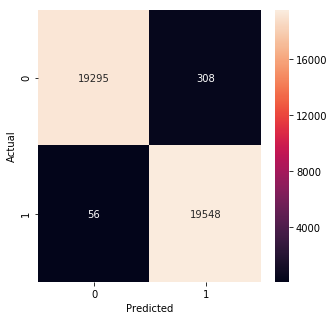

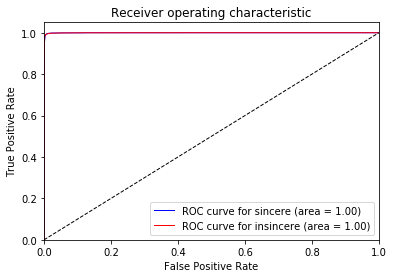

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.64      0.77    196036
   Insincere       0.12      0.72      0.20     12928

    accuracy                           0.64    208964
   macro avg       0.54      0.68      0.48    208964
weighted avg       0.92      0.64      0.73    208964



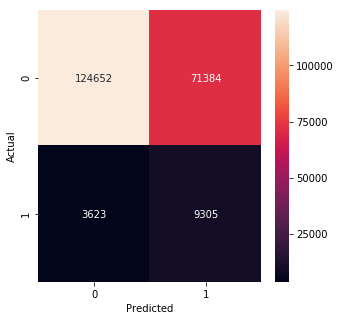

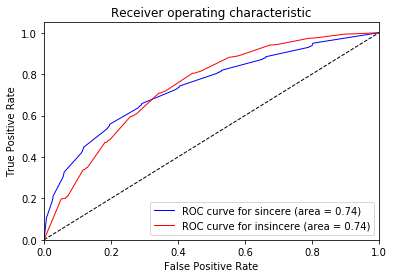

In [86]:
report(rfModel, X_train, y_train, alg_train_compare, 'rfModel')
report(rfModel, X_test, y_test, alg_test_compare, 'rfModel')

In [87]:
%%time

#for Algorithm (GradientBoosting)
from sklearn.ensemble import GradientBoostingClassifier

gbModel = GradientBoostingClassifier(random_state = 42,).fit(X_train, y_train)


CPU times: user 1min 56s, sys: 244 ms, total: 1min 56s
Wall time: 1min 57s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.67      0.92      0.77     19603
   Insincere       0.87      0.54      0.67     19604

    accuracy                           0.73     39207
   macro avg       0.77      0.73      0.72     39207
weighted avg       0.77      0.73      0.72     39207


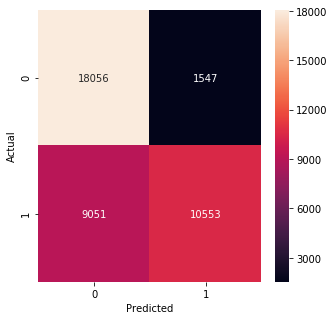

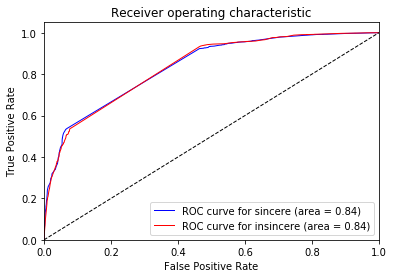

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.92      0.94    196036
   Insincere       0.31      0.58      0.40     12928

    accuracy                           0.89    208964
   macro avg       0.64      0.75      0.67    208964
weighted avg       0.93      0.89      0.91    208964


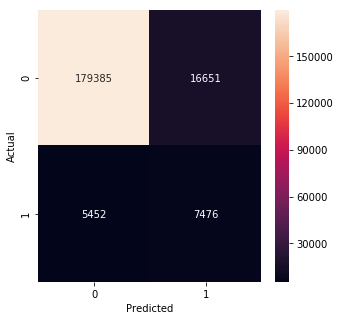

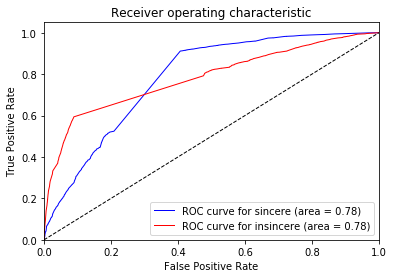

In [88]:
report(gbModel, X_train, y_train, alg_train_compare, 'gbModel')
report(gbModel, X_test, y_test, alg_test_compare, 'gbModel')

<B>summary on matrix</B>

In [89]:
# report the diff for 2.5% data on algorithms 
for key in alg_train_compare:
    print(key)
    print(alg_train_compare[key])

nbModel
              precision    recall  f1-score   support

     Sincere       0.80      0.97      0.88     19603
   Insincere       0.96      0.76      0.85     19604

    accuracy                           0.86     39207
   macro avg       0.88      0.86      0.86     39207
weighted avg       0.88      0.86      0.86     39207

lgModel
              precision    recall  f1-score   support

     Sincere       0.95      0.93      0.94     19603
   Insincere       0.93      0.96      0.94     19604

    accuracy                           0.94     39207
   macro avg       0.94      0.94      0.94     39207
weighted avg       0.94      0.94      0.94     39207

svcModel
              precision    recall  f1-score   support

     Sincere       0.95      0.97      0.96     19603
   Insincere       0.97      0.95      0.96     19604

    accuracy                           0.96     39207
   macro avg       0.96      0.96      0.96     39207
weighted avg       0.96      0.96      0.96     3

In [90]:
# report the diff for 2.5% data on algorithms 
for key in alg_test_compare:
    print(key)
    print(alg_test_compare[key])

nbModel
              precision    recall  f1-score   support

     Sincere       0.96      0.95      0.95    196036
   Insincere       0.36      0.47      0.41     12928

    accuracy                           0.92    208964
   macro avg       0.66      0.71      0.68    208964
weighted avg       0.93      0.92      0.92    208964

lgModel
              precision    recall  f1-score   support

     Sincere       0.97      0.85      0.91    196036
   Insincere       0.21      0.59      0.31     12928

    accuracy                           0.84    208964
   macro avg       0.59      0.72      0.61    208964
weighted avg       0.92      0.84      0.87    208964

svcModel
              precision    recall  f1-score   support

     Sincere       0.95      0.93      0.94    196036
   Insincere       0.18      0.21      0.19     12928

    accuracy                           0.89    208964
   macro avg       0.56      0.57      0.57    208964
weighted avg       0.90      0.89      0.89    20

## Step 6.2 hyperparameter Tuning (Grid Search) for Best Candidate Algorithm

Perform the hyperparameter turing on logisticRegression and selected algrithm from the above step (according to best insincere f1-score), use 25% of the SMOTE training data.

Report the result on train and test set and plot the grid seaarch score, 

Re-fit the best model using full SMOTE training set and report the result on hold-out data set


In [91]:
#all training data
X_train =load('data/sample_X_train.sav')
y_train =load('data/sample_y_train.sav')

X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size = 0.75, train_size = 0.25, random_state = 42, stratify = y_train)
print(X_train.shape, y_train.shape)

hyper_compare = {}


(392070, 196257) (392070,)


/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.92      0.94    196035
   Insincere       0.92      0.95      0.94    196035

    accuracy                           0.94    392070
   macro avg       0.94      0.94      0.94    392070
weighted avg       0.94      0.94      0.94    392070



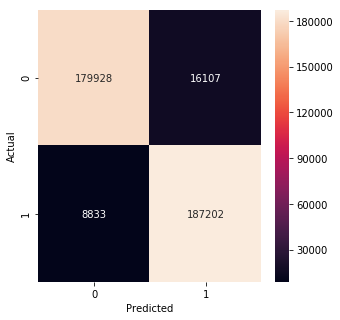

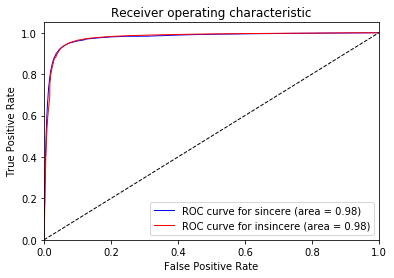

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.89      0.93    196036
   Insincere       0.25      0.57      0.35     12928

    accuracy                           0.87    208964
   macro avg       0.61      0.73      0.64    208964
weighted avg       0.92      0.87      0.89    208964



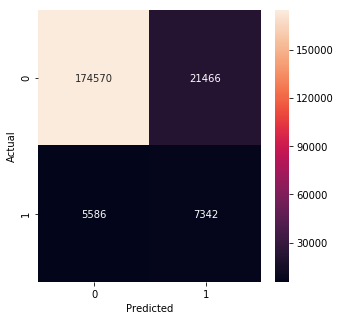

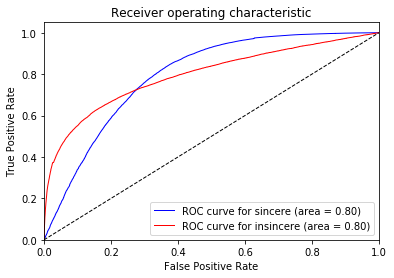

CPU times: user 1h 34min 34s, sys: 1min 7s, total: 1h 35min 42s
Wall time: 1h 20min 27s


In [92]:
%%time

from sklearn.linear_model import LogisticRegression
import numpy as np

param_grid = {'C': [0.001, 0.05, 0.1, 1, 10, 100], 
              'solver':['liblinear','newton-cg','lbfgs','sag'],}        
e = LogisticRegression(max_iter = 1000, random_state = 42, verbose = 0)
search_lr = GridSearchCV(e, param_grid, cv = 5, verbose = 0, scoring = 'roc_auc')
search_lr.fit(X_train, y_train)
best_lr = search_lr.best_estimator_ 
best_lr.fit(X_train, y_train)

name = 'data/lrReSampledModel.sav'
dump(best_lr, name)

report(best_lr, X_train, y_train, hyper_compare, 'LogisticRegression-train')
report(best_lr, X_test, y_test, hyper_compare, 'LogisticRegression-test')


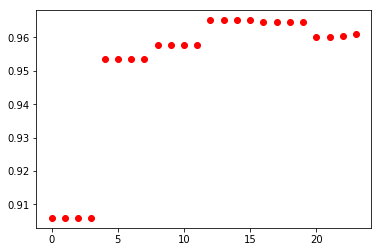

In [94]:
plt.plot(search_lr.cv_results_['mean_test_score'], 'ro')
plt.show()

LogisticRegression has very limited parameter, on the other hands, GridentBoostring has lists of parameters to consider, including range and type. [this article](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) and [this article](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae) is the reference been used. So, a two stage approaches, fitst stage is small smaple, larger range of parameter, second stage to nerrow down what looks promise. 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features=500, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=1500,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.86      0.91    196036
   Insincere       0.22      0.61      0.33     12928

    accuracy                           0.84    208964
   macro avg       0.60      0.74      0.62    208964
weighted avg       0.92      0.84      0.88    2089

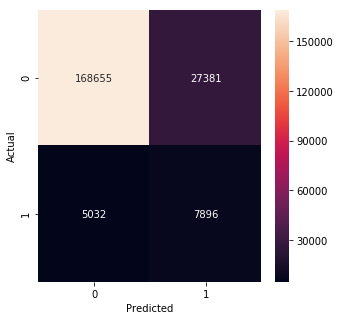

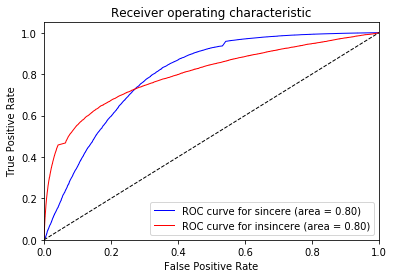

CPU times: user 1h 23min 11s, sys: 1min 3s, total: 1h 24min 15s
Wall time: 1h 4min 26s


In [97]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
'''
Tree-Specific Parameters: 
   max_depth (high will be over fit) or max_leaf_nodes  
   min_samples_split(high value to prevent overfit), 
   max_features  sqrt of total feature
   min_weight_fraction_leaf or min_samples_leaf(low for imbalanced)
Boosting Parameters
   learning_rate: lower value for robust
   n_estimators: high number 
   subsample: slightly less than 1  (~0.8)
Miscellaneous Parameters
   loss: 
   init:
   random_state
   verbose: 0, 1, > 1
   warm_start
   presort
'''
param_grid = {'max_depth' : [5,8] , 
              'min_samples_split' : np.linspace(0.1, 1.0, 4, endpoint=True) , 
              'max_features' : [500] , 
              'min_samples_leaf' : [50, 100, 200] , 
              'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2] , 
              'n_estimators':[100, 500, 1000, 1500], 
              'subsample' : [0.8], 
              } 

# 1% of test data only
X_small, _, y_small, _ = train_test_split(X_train, y_train, test_size = 0.99, train_size = 0.01, random_state = 42, stratify = y_train)

e = GradientBoostingClassifier(random_state=42, verbose=0)

search_test = GridSearchCV(e, param_grid, cv=5, verbose=0, scoring='roc_auc')
search_test.fit(X_small, y_small)
best_test= search_test.best_estimator_ 

best_test.fit(X_train, y_train)
report(best_test, X_test, y_test, hyper_compare, 'Selected-test')

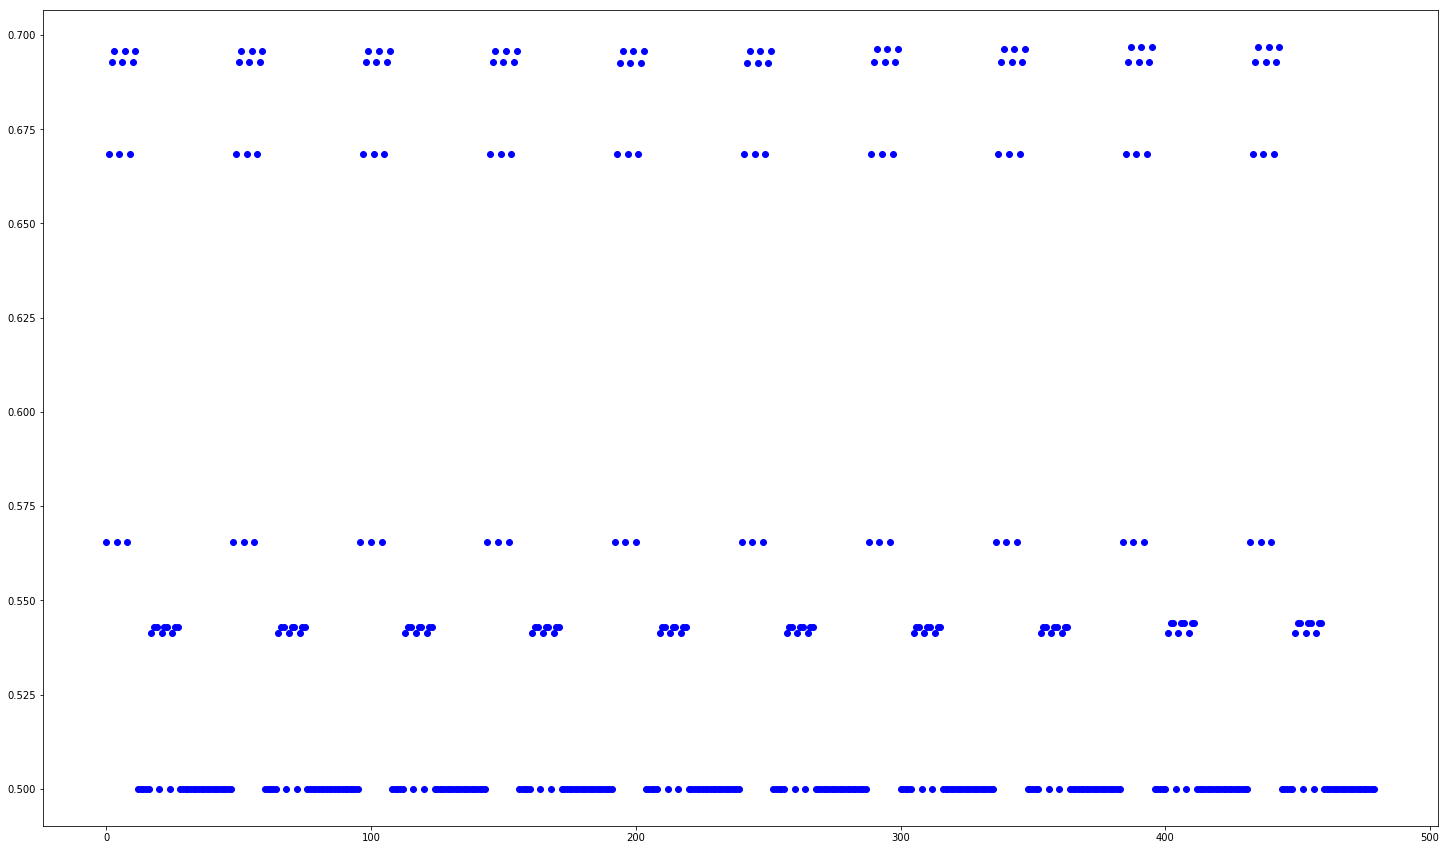

In [106]:
plt.figure(figsize=(25,15))
plt.plot(search_test.cv_results_['mean_test_score'], 'bo')
plt.show()

In [112]:
# from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig


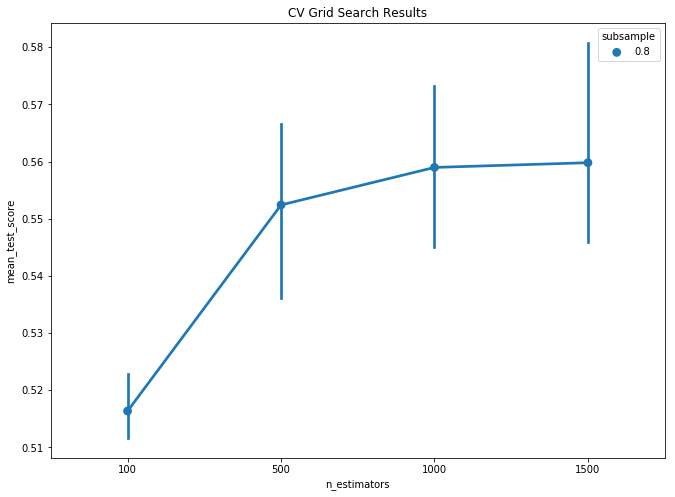

In [127]:
param_grid = {'max_depth' : [5,8] , 
              'min_samples_split' : np.linspace(0.1, 1.0, 4, endpoint=True) , 
              'max_features' : [500] , 
              'min_samples_leaf' : [50, 100, 200] , 
              'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2] , 
              'n_estimators':[100, 500, 1000, 1500], 
              'subsample' : [0.8], 
              } 
#fig = plot_cv_results(search_test.cv_results_,  'min_samples_split', 'subsample')
fig = plot_cv_results(search_test.cv_results_,  'n_estimators', 'subsample')

In [111]:
search_test.cv_results_['rank_test_score']
search_test.cv_results_['params'][-37]

{'learning_rate': 0.2,
 'max_depth': 8,
 'max_features': 500,
 'min_samples_leaf': 50,
 'min_samples_split': 0.7,
 'n_estimators': 1500,
 'subsample': 0.8}

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

param_grid = {'max_depth' : [8] , 
              'min_samples_split' : [0.1] , 
              'min_samples_leaf' : [20, 50] , 
              'learning_rate' : [0.1, 0.2, 0.3] , 
              'n_estimators':[1000, 1500, 2000], 
              'subsample' : [0.8],
              } 

e = GradientBoostingClassifier(random_state=42, verbose=1)

searchBest = GridSearchCV(e, param_grid, cv=5, verbose=0, scoring='roc_auc')
searchBest.fit(X_train, y_train)
best_s= searchBest.best_estimator_ 
best_s.fit(X_train, y_train)

name = 'data/bestReSampledModel.sav'
dump(best_s, name)

report(best_s, X_train, y_train, hyper_compare, 'Selected-train')
report(best_s, X_test, y_test, hyper_compare, 'Selected-test')

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3590           0.0273          412.32m
         2           1.3365           0.0218          413.03m
         3           1.3189           0.0188          412.70m
         4           1.3029           0.0156          412.31m
         5           1.2892           0.0132          413.03m
         6           1.2783           0.0110          412.23m
         7           1.2666           0.0114          411.30m
         8           1.2566           0.0090          410.52m
         9           1.2477           0.0096          409.95m
        10           1.2386           0.0085          409.53m
        20           1.1780           0.0047          405.38m
        30           1.1357           0.0033          401.14m
        40           1.1022           0.0027          396.87m
        50           1.0757           0.0023          392.56m
        60           1.0539           0.0018          388.33m
       

In [ ]:
#re-fit use all training data to predict the hold-ot data set
X_train =load('data/sample_X_train.sav')
y_train =load('data/sample_y_train.sav')

best_lr.fit(X_train, y_train)
best_s.fit(X_train, y_train)

report(best_lr, X_hold, y_hold, hyper_compare, 'LogisticRegression-hold')
report(best_s, X_hold, y_hold, hyper_compare, 'Selected-hold')

## Step 6.3 report the score for best model on hold out set 

In [ ]:
plt.plot(searchBest.cv_results_['mean_test_score'], 'bo')
plt.plot(searchLg.cv_results_['mean_test_score'], 'ro')
plt.show()

In [ ]:
for key in hyper_compare:
    print(key)
    print(hyper_compare[key])


<B>Reference</B>

Progress bar?  [Progress Bars in Python
](https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482),   Do we have progress bar for sklearn ? verbose=1 for now 

[Multi-Class Text Classification Model Comparison and Selection](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568)

<B>[Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)</B>

<B>information for next step</B>

<B>[A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)</B>

<B>[An implementation guide to Word2Vec using NumPy and Google Sheets](https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281)</B>

<B>[Approaching (Almost) Any NLP Problem on Kaggle](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle)</B>